In [3]:
import glob
import pandas as pd
df = pd.DataFrame(columns=["path", "target"])
fn = glob.glob("train/cat.*.jpg")
for f in fn:
    s = pd.Series([f, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
fn = glob.glob("train/dog.*.jpg")

for f in fn:
    s = pd.Series([f, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,train\cat.0.jpg,0
1,train\cat.1.jpg,0
2,train\cat.10.jpg,0
3,train\cat.100.jpg,0
4,train\cat.1000.jpg,0
5,train\cat.10000.jpg,0
6,train\cat.10001.jpg,0
7,train\cat.10002.jpg,0
8,train\cat.10003.jpg,0
9,train\cat.10004.jpg,0


0:貓, 1:狗 1
大小: (315, 500)


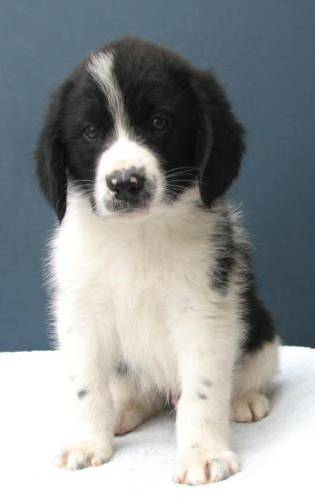

In [59]:
import random
from PIL import Image
c = random.randint(0, 24999)
data = df.iloc[c]
print("0:貓, 1:狗", data["target"])
img = Image.open(data["path"])
print("大小:", img.size)
img

In [72]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [61]:
vgg.layers

In [73]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
#!!!!!
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
# x = Dense(1, activation="sigmoid")(x)
x = Dense(2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
#!!!!
for l in vgg.layers:
    l.trainable = False
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [74]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [75]:
# 傳進去前全部變成numpy array
import numpy as np
from keras.utils.np_utils import to_categorical
x_np = np.array(df["path"])
y_np = np.array(df["target"])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [36]:
y_train[0]

array([0., 1.], dtype=float32)

In [80]:
from keras.applications.vgg16 import preprocess_input
train_count = 5
batch = 20
for times in range(train_count):
    # numpy randint, 第三個數字是不包含的
    idx = np.random.randint(0, x_train.shape[0], 20)
    x = []
    for fn in x_train[idx]:
        img = np.array(Image.open(fn).resize((224, 224)))
        img = preprocess_input(img)
        x.append(img)
    y = y_train_cat[idx]
    x = np.array(x)
    loss = cnn.train_on_batch(x, y)
    print("-" * 10, "Train", times, "-" * 10)
    print(loss)

---------- Train 0 ----------
[1.4086506, 0.85]
---------- Train 1 ----------
[3.8203301, 0.75]
---------- Train 2 ----------
[3.5362766, 0.7]
---------- Train 3 ----------
[0.00020082512, 1.0]
---------- Train 4 ----------
[0.00044170092, 1.0]


In [89]:
idx = np.random.randint(0, x_test.shape[0], 100)
x = []
for fn in x_test[idx]:
    img = np.array(Image.open(fn).resize((224, 224)))
    img = preprocess_input(img)
    x.append(img)
y = y_test_cat[idx]
y_ori = y_test[idx]
x = np.array(x)
cnn.evaluate(x, y)

100/100 [==============================] - 33s 325ms/step


[0.7375061273574829, 0.94]

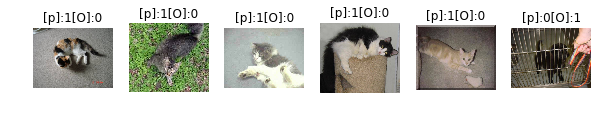

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
pre = cnn.predict(x).argmax(axis=-1)
notimg = []
notp = []
notori = []
notpath = []
plt.figure(figsize=(10, 10))
for (i, p) in enumerate(pre):
    if not p == y_ori[i]:
        notp.append(p)
        notori.append(y_ori[i])
        notimg.append(Image.open(x_test[idx][i]))
        notpath.append(x_test[idx][i])
for (i, img) in enumerate(notimg):
    plt.subplot(1, len(notimg), i + 1)
    plt.axis("off")
    plt.title("[p]:" + str(notp[i]) + "[O]:" + str(notori[i]))
    plt.imshow(img)

In [93]:
notpath

['train\\cat.7122.jpg',
 'train\\cat.6695.jpg',
 'train\\cat.1232.jpg',
 'train\\cat.5190.jpg',
 'train\\cat.9655.jpg',
 'train\\dog.1311.jpg']